# Import Software Libraries

In [1]:
import datetime as dt  # Work with datetime types.
import os  # Interact with the operating system.
import sys  # Read system parameters.
from io import StringIO  # Read and write strings as files
from urllib.parse import urlparse  # Parse url and extract path component

import matplotlib
import matplotlib.pyplot as plt
import numpy as np  # Work with multi-dimensional arrays and matrices.
import pandas as pd  # Manipulate and analyze data frames.
import requests  # Send HTTP requests
import sklearn  # Perform feature engineering and machine learning.
import statsmodels  # Perform statistical modeling.

# Summarize software libraries used.
print("Libraries used in this project:")
print("- NumPy {}".format(np.__version__))
print("- pandas {}".format(pd.__version__))
print("- scikit-learn {}".format(sklearn.__version__))
print("- statsmodels {}".format(statsmodels.__version__))
print("- Matplotlib {}".format(matplotlib.__version__))
print("- Python {}\n".format(sys.version))

Libraries used in this project:
- NumPy 1.24.3
- pandas 2.0.3
- scikit-learn 1.3.2
- statsmodels 0.14.1
- Matplotlib 3.7.2
- Python 3.8.18 | packaged by conda-forge | (default, Dec 23 2023, 17:23:49) 
[Clang 15.0.7 ]



# Load Dataset

In [2]:
# Capture URL
url = "https://raw.githubusercontent.com/tyrantdavis/datasets/refs/heads/main/elect_net_gen_solar.csv"
request = requests.get(url).text

# Save as dataframe and copy
original = pd.read_csv(StringIO(request), index_col="Date")
df = original.copy()

# Parse URL
parsed_url = urlparse(url)
path = parsed_url.path
filename = os.path.basename(path)


print(f"Loaded {len(df)} records form {filename}.")
print(df.tail())

Loaded 591 records form elect_net_gen_solar.csv.
          ElectNetGen
Date                 
2021 11      7873.778
2021 12      6354.878
2022 01      8003.896
2022 02      9202.560
2022 03     11890.566


# Get Acquainted with the Dataset

In [3]:
print(df.info())
df

<class 'pandas.core.frame.DataFrame'>
Index: 591 entries, 1973 01  to 2022 03 
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ElectNetGen  459 non-null    float64
dtypes: float64(1)
memory usage: 9.2+ KB
None


,ElectNetGen
Date,
1973 01,NaN
1973 02,NaN
1973 03,NaN
1973 04,NaN
1973 05,NaN
...,...
2021 11,7873.778
2021 12,6354.878
2022 01,8003.896


**Spotlights**

• The data frame consists of a single column named ElectNetGen.  
• ElectNetGen contains floating point numbers.  
• The data frame has a Date index that captures the month and year of each record. This will be converted to a datetime format for simplicity.  
• The net electricity generated is quantified in gigawatt-hours (GWh), equivalent to one million kilowatt-hours (kWh).  
• Some of the earlier years have missing entries. This is understandable as solar power is a relatively recent development. However, these missing values will need to be addressed. 

# Process `Date` Index to Datetime Format Conversion 

In [4]:
df.index = pd.to_datetime(df.index).to_period("M")  # Specify months.
df.head()
print("The Date index is now properly formatted.")

The Date index is now properly formatted.


/var/folders/yk/_g2wb8q55v9gmytn656hxt7h0000gp/T/ipykernel_38862/2223087393.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df.index).to_period("M")  # Specify months.


# Plot Net Electricity Generation

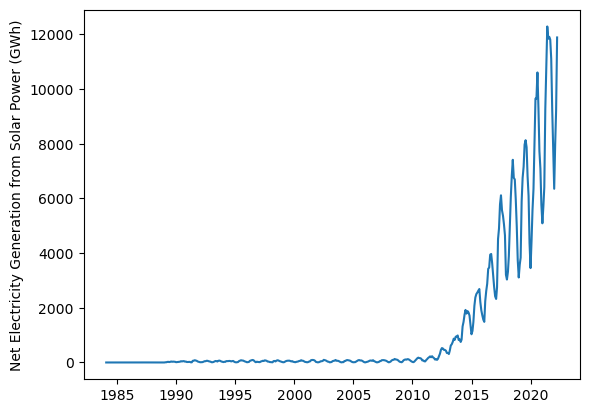

In [5]:
plt.plot_date(df.index, df["ElectNetGen"], fmt="-")
plt.ylabel("Net Electricity Generation from Solar Power (GWh)");

**Spotlights** 

There has been a notable increase in solar energy usage over the years, with the most significant growth occurring around the mid-2010s. Given that prior years experienced minimal to no electricity generation from solar power, it may be prudent to exclude that data from the analysis. Therefore, all measurements recorded before 2015 will be treated as outliers.

# Eliminate Months with Minimal Solar-Power Generation

In [6]:
# Remove designated outliers
df = df.loc[df.index.year >= 2015]
df

,ElectNetGen
Date,
2015-01,1155.351
2015-02,1483.554
2015-03,2072.257
2015-04,2379.118
2015-05,2504.149
...,...
2021-11,7873.778
2021-12,6354.878
2022-01,8003.896


The dataset now encompasses measurements from January 2015 onward. This effectively addressed previous issues with missing data as well.